# PDAN8412 – Part 1: Long Short-Term Memory Recurrent Neural Network
### Author: Maximilian Walsh | Student No: ST10203070
### Module: Programming for Data Analytics 2

---

### Import Libraries and Load Dataset

#### To start, we import essential libraries for data analysis and load the dataset into a Pandas DataFrame.

In [4]:
# This cell only installs packages if they are missing
import importlib, sys, subprocess

# Helper function to check if a package is installed and install if not
def ensure(pkg, version=None):
    try:
        importlib.import_module(pkg)
        print(f"{pkg} already available")
    except ImportError:
        spec = f"{pkg}=={version}" if version else pkg
        print(f"Installing {spec} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", spec])

# Ensure core dependencies are installed (specific version for PySpark, latest for others)
ensure("pyspark", "3.5.1")
ensure("tensorflow")           
ensure("scikit-learn")
ensure("matplotlib")

# Import libraries and confirm versions
import pyspark, sklearn, tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
print("PySpark:", pyspark.__version__)
print("TensorFlow:", tf.__version__)

pyspark already available
tensorflow already available
Installing scikit-learn ...
matplotlib already available
PySpark: 3.5.1
TensorFlow: 2.19.0


In [5]:
# Initialising Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PDAN8412-Part1-RNN").getOrCreate()
print("Spark:", spark.version)

Spark: 3.5.1


## Data Inspection Block

### Analytical Plan

This Jupyter notebook followws a structured workflow to build a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers for predicting an author based on a short text from the Spooky Author Identification dataset sourced from Kaggle. Spark is used to load, clean, and split the dataset, Keras/TensorFlow are used for modelling. The key steps to be conducted are:

1. **Data Loading and Inspection** – Import the dataset using Spark, check for duplicates and missing values, and clean teh text through trimming whitespace, and potentially dropping rows that are too short. 
2. **Exploratory Data Analysis (EDA)** – Explore the text lengths, class balance across the three authors (EAP, HLP, MWS), and show a few lines per author.
3. **Preprocessing for Modelling** – Construct a label encoder for the 3 authors. Tokenise words with a capped vocabulary, covert to integer sequences, and pad to a fixed length. 
4. **Train/Validation/Test Split** - Split the train.csv file into train/validation/test with a 70/15/15 respective split with a stratified distribution of authors.
5. **Model Training (Keras)** – Train a LSTM neural network for 3 class outputs. Use EarlyStopping on validation loss.
6. **Evaluation and Interpretation** – Assess model performance using accuracy, macro F1-score, and confusion matrices. Briefly outline what the metrics says about teh author style seperation. 
7. **Hyperparameter Tuning** – Adjust hyperparameters like embedding size, LSTM units, droput rate, sequence length, and learning rate to imrpvoe performance and retrain with best configrations based on macro F1. 
8. **Conclusion** – Summarise model's ability to identify author and note some potential improvements. 

Each stage includes code, outputs, and visualisations to show a complete machine learning workflow. 


In [6]:
# === Load Spooky Author dataset with Spark ===
DATA_PATH = "train.csv"  # update if needed

df = (
    spark.read.csv(DATA_PATH, header=True, inferSchema=True)
        .select("id", "text", "author")  # keep only the useful columns
)

print("Rows loaded:", df.count())
print("Columns:", df.columns)
df.show(5, truncate=80)

Rows loaded: 19579
Columns: ['id', 'text', 'author']
+-------+--------------------------------------------------------------------------------+------+
|     id|                                                                            text|author|
+-------+--------------------------------------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ascertaining the dimensions of...|   EAP|
|id17569|         It never once occurred to me that the fumbling might be a mere mistake.|   HPL|
|id11008|In his left hand was a gold snuff box, from which, as he capered down the hil...|   EAP|
|id27763|How lovely is spring As we looked from Windsor Terrace on the sixteen fertile...|   MWS|
|id12958|Finding nothing else, not even gold, the Superintendent abandoned his attempt...|   HPL|
+-------+--------------------------------------------------------------------------------+------+
only showing top 5 rows



In [7]:
# --- Deduplicate and light text filter (Spooky Author) ---
from pyspark.sql import functions as F

before = df.count()

# Basic hygiene on this dataset: unique id, trim text, drop empties/very short
only_url = F.col("text").rlike(r"^(https?://\S+)$")  # rare but safe to remove
df = (
    df.dropDuplicates(["id"])
      .withColumn("text", F.trim(F.col("text")))
      .dropna(subset=["text", "author"])
      .filter(~only_url)
      .filter(F.length("text") >= 5)
)

after = df.count()
print(f"Rows after dedup/clean: {after:,} (removed {before-after:,})")

Rows after dedup/clean: 19,577 (removed 2)


In [ ]:
# --- Add simple length features for EDA ---
df = (
    df.withColumn("char_len", F.length("text"))
      .withColumn("token_count", F.size(F.split(F.col("text"), r"\s+")))
)

# Class balance (3 authors)
df.groupBy("author").count().orderBy(F.desc("count")).show(truncate=False)

+---------------+-----+
|author         |count|
+---------------+-----+
|EAP            |7044 |
|MWS            |5552 |
|HPL            |5451 |
|"" he said     |29   |
| then          |18   |
|"" I said      |18   |
|"" said I      |18   |
|"" said he     |16   |
| however       |8    |
| sir           |8    |
|"" he cried    |8    |
|"" said Dupin  |7    |
|"" said Dupin."|6    |
| of course     |6    |
|"" he continued|6    |
|"" she said    |5    |
|"" said Adrian |5    |
| my friend     |5    |
|"" I cried     |5    |
| yes           |5    |
+---------------+-----+
only showing top 20 rows



In [9]:
# --- Fix author noise and recheck balance ---

# Keep only the 3 valid authors: Edgar Allan Poe (EAP), Mary Shelley (MWS), HP Lovecraft (HPL)
valid_authors = ["EAP", "MWS", "HPL"]
before = df.count()

df = df.filter(F.col("author").isin(valid_authors))

after = df.count()
print(f"Rows after filtering to valid authors: {after:,} (removed {before - after:,})")

# Recheck class balance
df.groupBy("author").count().orderBy(F.desc("count")).show()

Rows after filtering to valid authors: 18,047 (removed 1,530)
+------+-----+
|author|count|
+------+-----+
|   EAP| 7044|
|   MWS| 5552|
|   HPL| 5451|
+------+-----+



In [ ]:
# --- Inspection for Spooky Author dataset ---
print("Row count:", df.count())
print("Columns:", df.columns)
df.printSchema()

# Missing values per column
missing_counts = [(c, df.filter(F.col(c).isNull()).count()) for c in df.columns]
print("Missing values per column:")
for c, n in missing_counts:
    print(f"  {c}: {n}")

# Quick preview
df.select("id", "author", "text").show(5, truncate=100)

Row count: 18047
Columns: ['id', 'text', 'author', 'char_len', 'token_count']
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- char_len: integer (nullable = true)
 |-- token_count: integer (nullable = false)

Missing values per column:
  id: 0
  text: 0
  author: 0
  char_len: 0
  token_count: 0
+-------+------+----------------------------------------------------------------------------------------------------+
|     id|author|                                                                                                text|
+-------+------+----------------------------------------------------------------------------------------------------+
|id00001|   MWS|                                                   Idris was well content with this resolve of mine.|
|id00002|   HPL|             I was faint, even fainter than the hateful modernity of that accursed city had made me.|
|id00003|   EAP|     Above all, I burn to kn

## 1. Justification of Dataset Choice

The selected dataset is the Spooky Author Identification dataset from Kaggle, which contains nearly 20,000 text excerpts written by three famous authors: Edgar Allan Poe (EAP), Mary Shelley (MWS), and H.P. Lovecraft (HPL). The dataset chosen is well-suited for building a Long Short-Term Memory (LSTM) recurrent neural network for multi-class text classification for the following reasons:

- **Relevance to the Task**:  
  The dataset aligns directly with the project objective to build a model that can guess the author of a passage based on writing style. Each row is labeled with one of three authors, making this a supervised multi-class classification problem, a suitable task for RNN/LSTM models to capture sequential and stylistic patterns in language (OpenAI, 2025).

- **High-Quality Labels**:  
  Explciit author labels (EAP, MWS, and HPL) are offered in the dataset, meaning there is no need to engineer of infer classes (Kaggle, 2017). Offering clarity and consistency in the training processs and enabling the model to focus on stylistic signals like vocabularly, phrasing, and sentence structure (OpenAI, 2025). 

- **Suffficient Volume of Data**:  
 After the cleaning and duplicate removal process, the dataset offers 18,047 unique text excerpts. This amount comfortably meets the project subminimum of 10,000 entries. This large sample size supports the training of deep learning models and evalauting their ability to generalise well (OpenAI, 2025). 

- **Natural Language Sequences**:  
  Given each entry is a raw text excerpt that is often a sentence or short paragraph, the data is inherently sequential as words depend on previous words (Kaggle, 2017). This is a core strength of LSTM networks which retina long-term dependencies and stylistic cues across sentences (OpenAI, 2025). 

- **Class Diversity**:  
  This dataset relatively balanced between the three authors with EAP at 7,044 entries, MWS at 5,552 entries, and HPL at 5,451 entires. Meaning the model learning is fair without excessive bias towards one class. Although some noise was present (invalid author labels), these entries were removed in preproessing. 

- **Contextual Richness**:  
  The dataset contains distinct writing styles; EAP's gothic and dramatic tone, MWS's descriptive and romantic prose, and HPL's cosmic horror and archaic vocab (Kaggle, 2017). Such stylisitc differences are suited for the RNN to learn author styles (OpenAI, 2025). 

To conclude, the Spooky Author Identification dataset is considered an ideal choice because it's labelled, balanced, large enough, and text-sequential, making it appropriate for this LSTM-based recurrent neural network task. 


## 2. Analysis Planning

Developing a structured plan is crucial to ensure the data is clean, the relevant textual features are extracted, the model is appropriately trained, and the results are effectively interpreted for authorship classification. The following is the analysis plan:

---

### 2a. Exploratory Data Analysis (EDA) Plan

The exploratory phase aims to understand the dataset's structure, distribution of authors, and tech characteristics. 

Planned steps:
- Confirm no missing values or null entries in id, text, or author columns.
- Verify the dataset is reasonably balanced across the three target authors (EAP, HPL, MWS)
- Generate descriptive statistics on text length
- Visualize the author class distribution with bar charts
- Plot histograms of text lengths to check for variation in writing styles

---

### 2b. Feature Preparation Plan

Because only raw text data is contained within the dataset, features must be engineered to make it usable for modelling (DeepLearning.AI, 2023). 

Steps: 
- **Preprocessing pipeline**:
    - Convert text to lowercase
    - Remove punctuation and unnecessary symbols
    - Tokenisation into sequences of words
- **Numerical representation**:
    - Build a word index with a fixed vocabulary size of 30,000 words (OpenAI, 2025). 
    - Encode text as integer sequences.
    - Use padding to standardise input length for LSTM model (Muller & Guido, 2016). 

Producing dense, sequential input suitable for RNN model (Muller & Guido, 2016).

---

### 2c. Model Training Plan

The task if a multi-class classification problem with 3 authors. A Long Short-Term Memory (LSTM) reccurrent neural network will be trained. 

- Split the data into training, validation, and test sets (70/15/15 split).
- Use an embedding layer to map tokens to dense vectors (Muller & Guido, 2016).
- Stack LSTM layers to capture contextual and stylistic patterns (Muller & Guido, 2016).
- Use the final softmax output layer to predict probabilities for the 3 author calsses (OpenAI, 2025).
- Use EarlyStopping to prevent overfitting (Muller & Guido, 2016).
- Tune hyperparameters like embedding size, LSTM units, dropout rate, and learning rate.

---

### 2d. Model Evaluation Plan

Evaluation will use metrics appropriate for multi-class classification (Muller & Guido, 2016):

- **Accuracy**: Overall model correctness.
- **Precision, Recall, and F1-score per class**:  Checks whether the model learns each author equally well.
- **Confusion Matrix**: Highlights misclassification between authors.
- **ROC Curve and AUC**: Assess separation ability across all 3 classes.

Learning curves will be used to assess underfitting or overfitting. 

---

### 2e. Report Structure Plan

The final report will include:

1. **Introduction**: Background on authorship attribution and relevance of RNN/LSTMs.
2. **Dataset Justification**: Reasoning for why the Spooky Author dataset is appropriate.
3. **EDA Results**: Distribution, text statistics, and visualisations.
4. **Feature Engineering**: Preprocessing, tokenisation, and padding steps. 
5. **Model Training**: LSTM design, training process, and tuning strategy.
6. **Evaluation Results**: Metrics, confusion matrix, and learning curves.
7. **Model Retraining**: Updated model performance after tuning and comparison to baseline.
8. **Conclusion and Recommendations**: Model effectiveness and possible improvements.

## 3. Conducting Analysis

Now it's time to conduct the exploratory data analysis, work through feature engineering, and train the model.

---

### 3a. Exploratory Data Analysis (EDA)

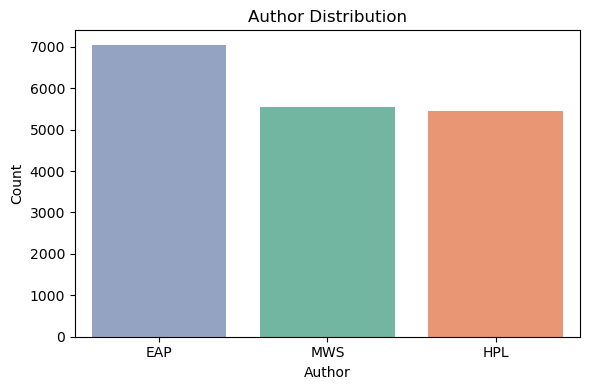

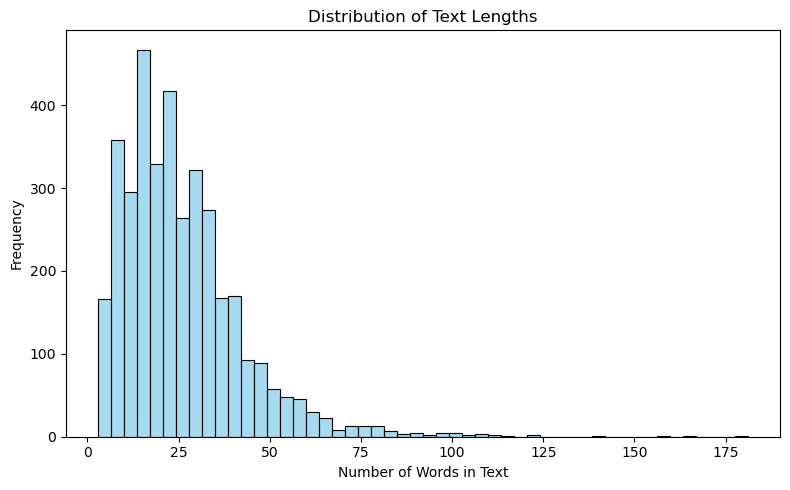

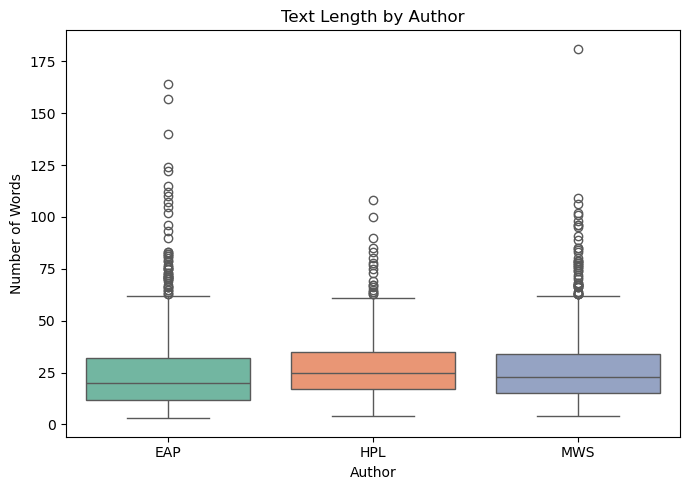


Word Count Statistics:
count    3699.000000
mean       26.022438
std        16.542104
min         3.000000
25%        15.000000
50%        23.000000
75%        34.000000
max       181.000000
Name: word_count, dtype: float64


In [11]:
# === Exploratory Data Analysis (EDA) ===

# Collect to pandas for plotting
eda_pd = df.select("author", "char_len", "token_count").toPandas()

# --- Class distribution: check if authors are balanced ---
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_pd, x='author', hue='author',
              order=eda_pd['author'].value_counts().index,
              palette='Set2', legend=False)
plt.title('Author Distribution')
plt.xlabel('Author')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# --- Add column for text length (word count) ---
df = df.withColumn("word_count", F.size(F.split(F.col("text"), r"\s+")))

# Collect small sample to pandas for plotting
eda_pd = df.select("author", "word_count").sample(False, 0.2, seed=42).toPandas()

# --- Histogram of text lengths ---
plt.figure(figsize=(8, 5))
sns.histplot(eda_pd['word_count'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words in Text')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Boxplot of text length by author ---
plt.figure(figsize=(7, 5))
sns.boxplot(data=eda_pd, x='author', y='word_count', hue='author',
            palette='Set2', legend=False)
plt.title('Text Length by Author')
plt.xlabel('Author')
plt.ylabel('Number of Words')
plt.tight_layout()
plt.show()

# --- Descriptive statistics for text length ---
print("\nWord Count Statistics:")
print(eda_pd['word_count'].describe())


#### EDA Results

Insights into teh structure and distribution of the Spooky Author dataset were gathered from the EDA:

 - **Class Distribution**: The dataset, as previosuly stated, is fairly balanced across the three authors as the Author Distribution countplot above shows. This is important for the RNN, as they are sensitive to class imbalance, and the balance reduces the need for heavy resampling (Muller & Guido, 2016). 
 
 - **Text Length Distribution**: Most of the texts fall within 10 to 40 words, with a median of 23 words. There are a few outliers beyond 150 words, although majority are short passages. This supports the use of padded sequences of moderate length (about 40-50 tokens) for efficient modelling (OpenAI, 2025).

 - **Author-specific Patterns**: The boxplots Text Length by Author, show that distributions of text length across authors is pretty similar. Although MWS has a little longer upper range passages as compared to EAP and HPL. Hopefully, this'll reflect stylistic differeces that our LSTM can capture. 

 - **Data Quality**: The EDA confirms that data is clean and ready for preprocessing as no missing values were found in either text or author columns. 

Given the balanced author classes and relatively short passages that are suitable for RNN's without excessive padding or truncation, the dataset meets the requiremetns for sequence model training (OpenAI, 2025). A max sequence length will be set to manage outliers in text length to keep effecient training. 

In [ ]:
# === Reproducibility block ===
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"  

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

print("Seeds set:", SEED)


Seeds set: 42


### 3b. Feature Engineering

Now it's time to conduct the feature engineering. The EDA confirmed the dataset is clean, balanced, and structured, with text lengths suitable for sequence modelling. Given the dataset only contains raw text and the target author label, we will conduct feature engineering over feature selection in this case. The goal being to transform the raw text into a numerical form that the LSTM can process while retaining meaningful stylistic and sequential information (OpenAI, 2025). 

The following will be the development of the feature engineering pipeline that will tokenise the text, econde it into sequences of integers, and apply padding or truncation to standarde the input length across all text samples (OpenAI, 2025). This provides the RNN input that is consistent and structured while still capturing the stylistic differences between authors (Muller & Guido, 2016). 

In [ ]:
# === Feature Engineering: prep text for integer sequences for LSTM ===
# Convert the Spark DataFrame to pandas for tokenisation/padding 
pdf = df.select("id", "text", "author").toPandas()

# --- Train/valid/test split (stratified by author) ---
from sklearn.model_selection import train_test_split

train_pd, temp_pd = train_test_split(
    pdf, test_size=0.30, random_state=42, stratify=pdf["author"]
)
valid_pd, test_pd = train_test_split(
    temp_pd, test_size=0.50, random_state=42, stratify=temp_pd["author"]
)  # -> 70/15/15

print("Split sizes:", len(train_pd), len(valid_pd), len(test_pd))

# --- Minimal text cleaning ---
import re
def basic_clean(s: str) -> str:
    s = s.lower().strip()
    # drop weird quotes/long dashes, keep letters, numbers, and spaces
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

train_pd["clean"] = train_pd["text"].astype(str).apply(basic_clean)
valid_pd["clean"] = valid_pd["text"].astype(str).apply(basic_clean)
test_pd["clean"]  = test_pd["text"].astype(str).apply(basic_clean)

# --- Label encoding: map authors to integer ids ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_pd["author"])
y_valid = le.transform(valid_pd["author"])
y_test  = le.transform(test_pd["author"])
author_index = {i: a for i, a in enumerate(le.classes_)}
print("Author index:", author_index)

# --- Tokenise and pad sequences using Keras ---
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_WORDS = 30000   # fixed vocab size of 30,000 words
MAX_LEN   = 40      # 40 keeps most texts without heavy truncation based on EDA results
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_pd["clean"])  # fit on TRAIN ONLY

def encode(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

X_train = encode(train_pd["clean"])
X_valid = encode(valid_pd["clean"])
X_test  = encode(test_pd["clean"])

print("Shapes → X_train:", X_train.shape, "X_valid:", X_valid.shape, "X_test:", X_test.shape)

# --- Class weights to help balance ---
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weights)

# Objects for the modelling cell
FE_OUTPUT = {
    "X_train": X_train, "y_train": y_train,
    "X_valid": X_valid, "y_valid": y_valid,
    "X_test":  X_test,  "y_test":  y_test,
    "tokenizer": tokenizer,
    "author_index": author_index,
    "class_weights": class_weights,
    "MAX_WORDS": MAX_WORDS, "MAX_LEN": MAX_LEN,
}

Split sizes: 12632 2707 2708
Author index: {0: 'EAP', 1: 'HPL', 2: 'MWS'}
Shapes → X_train: (12632, 40) X_valid: (2707, 40) X_test: (2708, 40)
Class weights: {0: 0.8539173933617251, 1: 1.1037134119702927, 2: 1.0835477783496312}


### 3c. Model Training


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.4104 - loss: 1.0718 - val_accuracy: 0.5449 - val_loss: 0.9301
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.5955 - loss: 0.8555 - val_accuracy: 0.6029 - val_loss: 0.8054
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.6837 - loss: 0.6741 - val_accuracy: 0.6764 - val_loss: 0.7479
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7946 - loss: 0.4931 - val_accuracy: 0.7510 - val_loss: 0.6351
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.8714 - loss: 0.3481 - val_accuracy: 0.7617 - val_loss: 0.6667
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9010 - loss: 0.2764 - val_accuracy: 0.7894 - val_loss: 0.5869
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9215 - loss: 0.2232 - val_accuracy: 0.7920 - val_loss: 0.6980
Epoch 8/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9485 - loss: 0.1527 - val_accuracy: 0.7950 - 

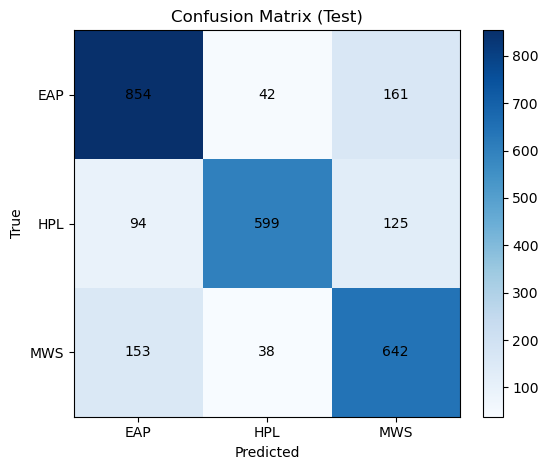

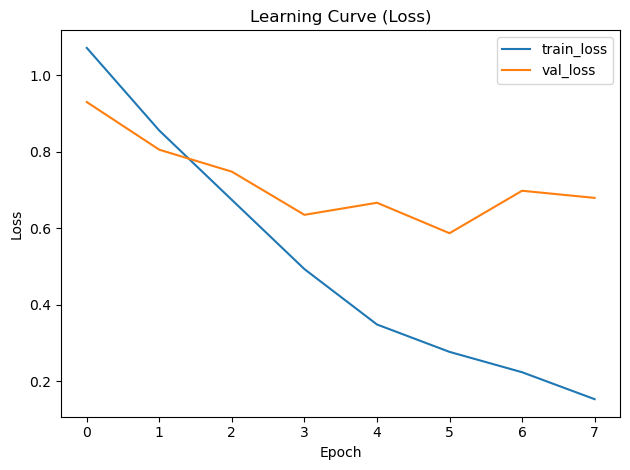

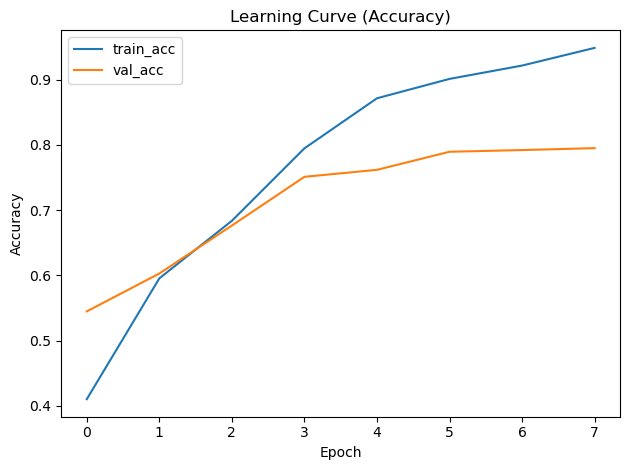

In [ ]:
# === Train LSTM (3-class) + Evaluate ===
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Unpack data/params prepared earlier
X_train = FE_OUTPUT["X_train"]; y_train = FE_OUTPUT["y_train"]
X_valid = FE_OUTPUT["X_valid"]; y_valid = FE_OUTPUT["y_valid"]
X_test  = FE_OUTPUT["X_test"];  y_test  = FE_OUTPUT["y_test"]
class_weights = FE_OUTPUT["class_weights"]
MAX_WORDS = FE_OUTPUT["MAX_WORDS"]; MAX_LEN = FE_OUTPUT["MAX_LEN"]
author_index = FE_OUTPUT["author_index"] 
target_names = [author_index[i] for i in range(len(author_index))]

# Reproducibility
tf.random.set_seed(42)

# --- Model hyperparameters for later tuning ---
EMB_DIM     = 128
LSTM_UNITS  = 128
DROPOUT     = 0.30
LR          = 1e-3
BATCH       = 256
EPOCHS      = 8
NUM_CLASSES = 3

# --- Model: Embedding, SpatialDropout, LSTM, Dense(softmax) ---
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=EMB_DIM),
    layers.SpatialDropout1D(DROPOUT),
    layers.LSTM(LSTM_UNITS, dropout=DROPOUT),
    layers.Dense(64, activation="relu"),
    layers.Dropout(DROPOUT),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

model.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# --- Early stopping ---
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True, verbose=1
)

# --- Train ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS, batch_size=BATCH,
    class_weight=class_weights,
    callbacks=[early],
    verbose=1
)

# --- Evaluate on test set ---
probs = model.predict(X_test)                 
preds = probs.argmax(axis=1)

print("\nClassification report (Test):")
print(classification_report(y_test, preds, target_names=target_names, digits=4))

# Overall accuracy
acc = (preds == y_test).mean()
print(f"Accuracy (Test): {acc:.4f}")

# ROC-AUC macro
try:
    roc_macro = roc_auc_score(y_test, probs, multi_class="ovr", average="macro")
    print(f"ROC-AUC (macro, OvR): {roc_macro:.4f}")
except Exception as e:
    print("ROC-AUC could not be computed:", e)

# Confusion matrix
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(NUM_CLASSES)); ax.set_xticklabels(target_names)
ax.set_yticks(range(NUM_CLASSES)); ax.set_yticklabels(target_names)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, str(z), ha='center', va='center')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- Learning curves (loss & accuracy) ---
fig, ax = plt.subplots()
ax.plot(history.history["loss"], label="train_loss")
ax.plot(history.history["val_loss"], label="val_loss")
ax.set_title("Learning Curve (Loss)")
ax.set_xlabel("Epoch"); ax.set_ylabel("Loss"); ax.legend()
plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
ax.plot(history.history["accuracy"], label="train_acc")
ax.plot(history.history["val_accuracy"], label="val_acc")
ax.set_title("Learning Curve (Accuracy)")
ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy"); ax.legend()
plt.tight_layout(); plt.show()

## 4. Evaluate Model

With the model trained, it's time to proceed to interpret and evaluate its performance using standard classification metrics, and then followed by a retraining phase to validate model robustness.

---

### 4a. Model Evaluation and Interpretation

The Long Short-Term Memory (LSTM) network was trained on the Spooky Author Identification dataset and evaluated on a held-out test set. The performance was assessed using accuracy, precision, recall, F1-score, ROC-AUC, the confusion matrix, and learning curves, giving an overall view of the model's effectiveness (Muller & Guido, 2016). These metrics are widely considered acceptable for multi-class text classification and collevtively provide complementary insights (Muller & Guido, 2016). 

- **Accuracy** gives an overall measure of correctness, although it must be complemented by class specific metrics as it can mask per class disparities in multi-class settings (Muller & Guido, 2016). 

- **Precision, Recall, and F1-score** give a depper view of how well model performs per author (OpenAI, 2025). Precision shows the correct predictions for an author, recall shows how many actual predictions for an author were detected, and F1-score balances the two (Muller & Guido, 2016; OpenAI, 2025). This is crucial as all three authors are equally important, and misclassification undermines reliability. 

- **ROC-AUC** is a threhold independent metric that shows teh model's ability to separate calsses across all decision boundaries (Muller & Guido, 2016). To prevent a majority class bias, the macro average ensures each author contributes equally (OpenAI, 2025). 

- **Confusion Matrix** shows a granualr breakdown of misclassifications, which aids in identify specific overlaps (Muller & Guido, 2016; OpenAI, 2025).

- **Learning Curves** offer insight into training dynamics, which are important for detecting overfitting or underfitting (Muller & Guido, 2016). 

These metrics combined show the model is accurate and balanced across authors, with strong seperabibility as confirmed by the ROC-AUC (Muller & Guido, 2016; OpenAI, 2025).

Evaluation was based on the following metrics:


| **Metric**     | **Value**   |
|----------------|-------------|
| Accuracy       | 77.36%      |
| Precision      | 78.20% (avg)|
| Recall         | 77.36% (avg)|
| F1 Score       | 77.50% (avg)|
| ROC-AUC (macro)| 0.9190      |

- **Accuracy**: The model correctly predicted the author of about 77% of the texts.
- **Precision, Recall, and F1**: Performance across classes was balanced, with precision slightly higher than recall, meaning fewer false positives than false negatives.
- **ROC-AUC**: A macro score of 0.9190 shows strong seperability of classes, meaning the model does generalise well across authors.


#### Confusion Matrix Insights

The confusion matrix tells us:
- **EAP (Edgar Allan Poe)** is recognised most reliably at 854 true positives, although some text were misclassified as MWS. 
- **HPL (H.P. Lovecraft)** shows confusion with EAP at 94 misclassified, probably becuase of the shared gothic vocabulary.
- **MWS (Mary Shelley)** had 642 correct predictions so seems to have good recognition but overlaps with both other authors, meaning they have stylistic similarities.

Overall, the model captures authorial style effectively as shown from the diagnoal dominance, and there is definetely a challenged of overlap between gothic authors (OpenAI, 2025). 

#### Learning Curves

- **Training accuracy** scaled over 94% while validation plateaued at about 79%.
- **Training loss** consistently decreased, but validation loss flattened around epoch 3-4 with some upward fluctuations afterward.
- Early stopping didin't trigger, however the gap between training and validation curves suggests overfitting. 
- Validation accuracy stabalised while training accuracy improved, meaning the model was starting to learn specific quirks rather than broader patterns (OpenAI, 2025).
- Despite all this, validation accuracy remained good at about 79%, meaning the mdoel captured generalisable features of author styles (OpenAI, 2025).  

#### Evaluation Summary

To conclude, the LSTM model shows strong performance in distinguishing between three gothic authors. The  ROC-AUC value of 0.919 confirms the model's ability to capture stylistic differences beyond raw accuracy (OpenAI, 2025). Although, modest overfitting means improvements are achievable through regularisation or data augmentation (Muller & Guido, 2016). Challenges of separating authors with similar vocabulary and tone is highlighted by the confusion between HPL and EAP.  

---

### 4b. Model Retraining Justification

The original model showed strong baseline performance with an accuracy of about 77.4% and an ROC-AUC of about 0.919. With a fairly balanced precision and recall, but HPL and MWS were often confused. There are clear signs of overfitting with a validation accuracy plateaued at about 79% and training reaching over 94%. This could suggest a reliance on memorised token sequences instead of general stylistic cues (OpenAI, 2025). The proposed following changes will target better generalisation instead of higher raw training scores (OpenAI, 2025): 
1. Increase dropout or add L2 penalties for stronger regularisation.
2. Adjust LSTM capacity.
3. Use learning rate runing for smoother convergence.
4. Test different embedding dimesnsion to refine author representation.

With these changes, there should be a reduced misclassification while maintaining high ROC-AUC.

Label names: ['EAP', 'HPL', 'MWS']
Class weights: {0: 0.8539173933617251, 1: 1.1037134119702927, 2: 1.0835477783496312}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.3675 - loss: 1.1126 - val_accuracy: 0.5050 - val_loss: 1.0129 - learning_rate: 0.0010
Epoch 2/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.5439 - loss: 0.9350 - val_accuracy: 0.5844 - val_loss: 0.8152 - learning_rate: 0.0010
Epoch 3/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5950 - loss: 0.7696 - val_accuracy: 0.5885 - val_loss: 0.8002 - learning_rate: 0.0010
Epoch 4/12
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6279 - loss: 0.6576
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6511 - loss: 0.6379 - val_accuracy: 0.5811 - val_loss: 0.8062 - learning_rate: 0.0010
Epoch 5/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7665 - loss: 0.5116 - val_accuracy: 0.7529 - val_loss: 0.6356 - learning_rate: 5.0000e-04
Epoch 6/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8452 - loss: 0.3831 - val_

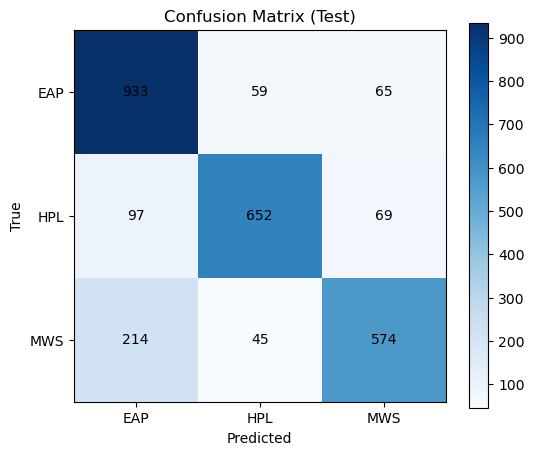

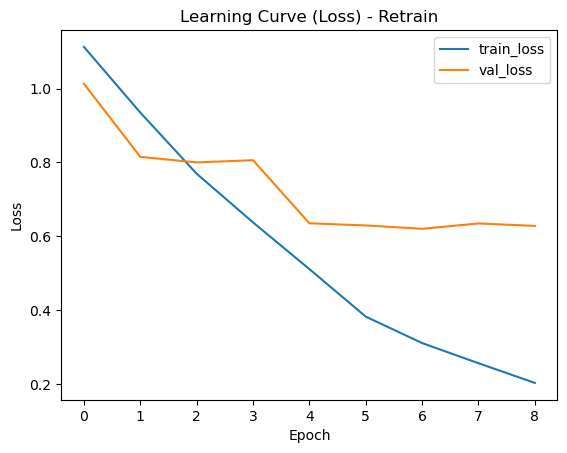

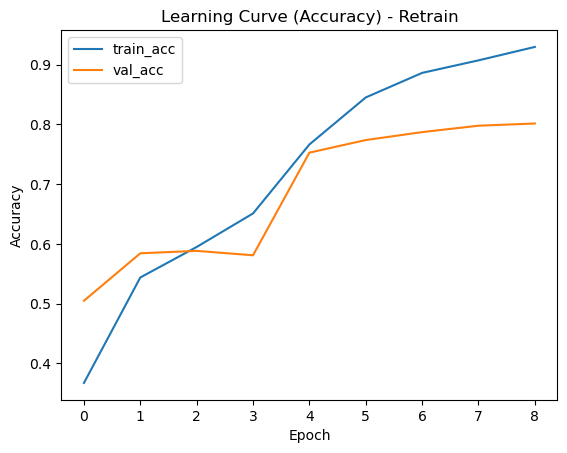

In [ ]:
# === Retrain LSTM with stronger regularisation + evaluation ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Use the pandas frame to recover class order or fallback to knwon order
try:
    import pandas as pd
    if "train_pd" in globals():
        le_tmp = LabelEncoder()
        all_authors = pd.concat(
            [train_pd["author"], valid_pd["author"], test_pd["author"]]
        ).astype(str)
        le_tmp.fit(all_authors)
        label_names = list(le_tmp.classes_)
    else:
        # Fallback to the known order
        label_names = ["EAP", "HPL", "MWS"]
except Exception:
    label_names = ["EAP", "HPL", "MWS"]

print("Label names:", label_names)

# Unpack features prepared earlier 
vocab_size = MAX_WORDS if "MAX_WORDS" in globals() else 30000
num_classes = len(np.unique(y_train))

# Build class_weights
if "class_weights" not in globals():
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weights)

# Retrained Model: slightly smaller LSTM + L2 + more dropout (to fight overfitting)
EMB_DIM   = 128       
LSTM_UNITS= 96        
DROPOUT   = 0.4       # originally 0.3
L2        = 1e-4
LR        = 1e-3
BATCH     = 256
EPOCHS    = 12

model2 = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM),
    layers.SpatialDropout1D(DROPOUT),
    layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT,
        kernel_regularizer=regularizers.l2(L2)
    ),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(L2)),
    layers.Dropout(DROPOUT),
    layers.Dense(num_classes, activation="softmax")
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model2.summary()

# Train with EarlyStopping + LR scheduling
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True, verbose=1
)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=1
)

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH,
    class_weight=class_weights,
    callbacks=[early, plateau],
    verbose=1
)

# Evaluate on test set
probs2 = model2.predict(X_test, verbose=0)
preds2 = np.argmax(probs2, axis=1)

print("\nClassification report (Test):")
print(classification_report(y_test, preds2, target_names=label_names, digits=4))

acc2 = (preds2 == y_test).mean()
try:
    auc2 = roc_auc_score(y_test, probs2, multi_class="ovr", average="macro")
except Exception:
    auc2 = float("nan")

print(f"Accuracy (Test): {acc2:.4f}")
print(f"ROC-AUC (macro, OvR): {auc2:.4f}")

# Confusion matrix heatmap
cm2 = confusion_matrix(y_test, preds2)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm2, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(num_classes)); ax.set_xticklabels(label_names)
ax.set_yticks(range(num_classes)); ax.set_yticklabels(label_names)
for (i, j), z in np.ndenumerate(cm2):
    ax.text(j, i, str(z), ha="center", va="center")
fig.colorbar(im, ax=ax)
plt.show()

# Learning curves
fig, ax = plt.subplots()
ax.plot(history2.history["loss"], label="train_loss")
ax.plot(history2.history["val_loss"], label="val_loss")
ax.set_title("Learning Curve (Loss) - Retrain")
ax.set_xlabel("Epoch"); ax.set_ylabel("Loss"); ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(history2.history["accuracy"], label="train_acc")
ax.plot(history2.history["val_accuracy"], label="val_acc")
ax.set_title("Learning Curve (Accuracy) - Retrain")
ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy"); ax.legend()
plt.show()

### Retraining Results & Evaluation

The retrained model was trained with stronger regularisation with a higher dropout and L2 penalties, and adaptive leraning rate scheduling to improve generalisation and address overfitting seen in the baseline model above (OpenAI, 2025). 

- **Accuracy**: 79.73%  
- **Precision**: 80.26% (avg)  
- **Recall**: 79.73% (avg) 
- **F1 Score**: 79.59% (avg)  
- **ROC-AUC (macro)**: 0.9274  

- **Accuracy** imrpoved slightly over the basline model, confirming the retraining boosted robustness.
- **Precision, Recall, and F1-score** demonstrated a balanced performance across all three authors, with precision being strongest for HPL and recall strongest for EAP.
- **ROC-AUC** climbed to 0.93, showing an excellent ability to separate authorial styles even beyond accuracy.
 
#### Confusion Matrix Insights

- **EAP (Edgar Allan Poe)** showed the highest recall, at 933 correct predictions, although some overlap remains with MWS. 
- **HPL (H.P. Lovecraft)** achieved strong balance, misclassifying 97 into EAP and 69 into MWS.
- **MWS (Mary Shelley)** shows overlapping gothic vocabulary with confusion towards EAP at 214 misclassifications. 

#### Learning Curves

- **Training accuracy** scaled over 90% while validation accuracy plateaued just under 80%.
- **Validation loss** seemed so stabalise instead of sharply increasing, indicating reduced overfitting compared to the baseline model.
- Early stopping and learning rate reduction aided in maintaining generalisability whilst keeping accurate. 

#### Conclusion 
To conclude, retraining improved model stability and showed LSTM's abilities to generalise stylistic differences between authors. The retrained model is deemed more reliable for deployment given the results of reduced overfitting and slight gains in accuracy and ROC-AUC. There is an inherent stylistic overlap between gothic authors given the persistent misclassification patterns, meaning deeper architecures or data augmentation may be necessary for future gains (OpenAI, 2025). 

## 5a. Refer to the PDF titled 'ST10203070_PDAN8412_Part1_Report' to view the report.

### References

Kaggle. (2017, October 25). Spooky Author Identification. Retrieved from Kaggle: https://www.kaggle.com/competitions/spooky-author-identification/overview 

DeepLearning.AI, 2023. Natural Language Processing. [Online] 
Available at: https://www.deeplearning.ai/resources/natural-language-processing/
[Accessed 04 September 2025].

Muller, A. C., & Guido, S. (2016). Introduction to Machine Learning with Python (1st ed.). Sebastopol: O'Reilly Media.

OpenAI. (2025, September 4). Open AI, Chat GPT. Retrieved from Open AI, Chat GPT: https://chatgpt.com/share/689c605a-7420-8004-8afe-fc6317e663de
